In [1]:
import os
os.chdir("src/")

from copy import deepcopy
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from game import gameEnvironmentClass, gridIsFinished
from neuralNetwork import DQN
from agent import agentClass
from main import runExperiment

# Train model on a given set for parameters

In [5]:
# hyperparameters
hyparameters = {"epsilon" : 0.1, #ratio exploration / exploitation
"gamma": 1, # relative importance of future reward
"memorySize" : 5000, # size of replay memory
"sampleSize" : 500, # number of experience we learn on, randomly sampled on replay memory
"reward_function" : "reward2", # reward function, see reward.py for details
"nn_model":"cnn", # model to evalutate state-action values
"use_cuda":True, # if you want the model to run on GPU
"epoch" : 200}

runExperiment(hyparameters)

Training 47099fbf-2408-11ed-ab90-7085c2a6b9e9 on cpu 
With parameters : {'epsilon': 0.1, 'gamma': 1, 'memorySize': 5000, 'sampleSize': 500, 'reward_function': 'reward2', 'nn_model': 'cnn', 'use_cuda': True, 'epoch': 200}
epoch 0 Loss = 7.3498907
epoch 1 Loss = 121.48817
epoch 2 Loss = 52.658108
epoch 3 Loss = 10.974724
epoch 4 Loss = 20.68367
epoch 5 Loss = 11.433878
epoch 6 Loss = 4.871575
epoch 7 Loss = 15.967483
epoch 8 Loss = 7.956134
epoch 9 Loss = 11.644554
epoch 10 Loss = 16.668055
epoch 11 Loss = 10.631741
epoch 12 Loss = 15.637482
epoch 13 Loss = 44.90625
epoch 14 Loss = 5.622775
epoch 15 Loss = 18.825333
epoch 16 Loss = 13.520566
epoch 17 Loss = 3.8446765
epoch 18 Loss = 6.7943797
epoch 19 Loss = 28.388954
epoch 20 Loss = 41.981827
epoch 21 Loss = 14.641594
epoch 22 Loss = 16.193235
epoch 23 Loss = 14.722854
epoch 24 Loss = 15.929432
epoch 25 Loss = 17.250257
epoch 26 Loss = 11.887177
epoch 27 Loss = 12.412511
epoch 28 Loss = 9.660836
epoch 29 Loss = 56.380657
epoch 30 Loss =

# Explore model results

In [7]:
modelDirectory = "../model/"
os.listdir(modelDirectory)

['.gitkeep', '47099fbf-2408-11ed-ab90-7085c2a6b9e9']

In [8]:
# retrieve models at every training steps, and run hyperparameters

run_id = "47099fbf-2408-11ed-ab90-7085c2a6b9e9"
modelPath = modelDirectory + run_id + "/"

with open(modelPath + "lossDict.pickle", "rb") as f:
    lossDict = pickle.load(f)
    
with open(modelPath + "modelWeightsDict.pickle", "rb") as f:
    modelWeightsDict = pickle.load(f)
    
with open(modelPath + "hyperparameters.json", "r") as f:
    hyperparameters = json.load(f)
    
print(hyperparameters)

{'epsilon': 0.1, 'gamma': 1, 'memorySize': 5000, 'sampleSize': 500, 'reward_function': 'reward2', 'nn_model': 'cnn', 'use_cuda': True, 'epoch': 200}


## Evolution of loss during training

Text(0, 0.5, 'Loss')

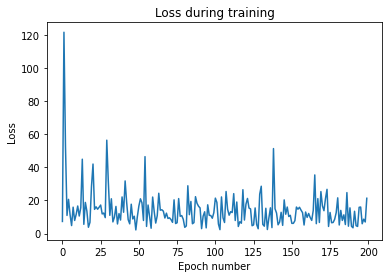

In [9]:
ax = plt.plot(lossDict.values())
plt.title("Loss during training")
plt.xlabel("Epoch number")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

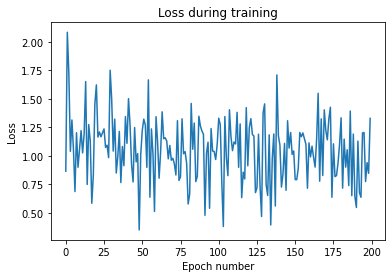

In [10]:
# same with log scale

val = [np.log10(el) for el in lossDict.values()]
ax = plt.plot(val)
plt.title("Loss during training")
plt.xlabel("Epoch number")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

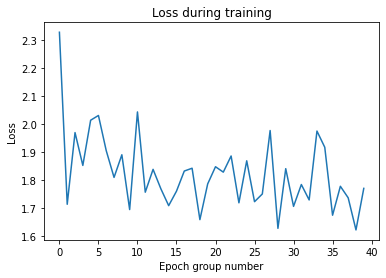

In [11]:
# log-average loss values, averaged over 5 epochs

val = np.array(list(lossDict.values()))
val = np.sum(val.reshape(-1, 5), axis=1) # average over 5 epochs
val = np.apply_along_axis(np.log10, 0, val) # take log
ax = plt.plot(val)
plt.title("Loss during training")
plt.xlabel("Epoch group number")
plt.ylabel("Loss")

# Study policy evolution

*Replay a game, with greedy policy*

*By retrieving Q model, at different steps of the training*

*And computing some KPIs to study the quality of policy at a given state*

In [12]:
env = gameEnvironmentClass() # same start game state

kpi1, kpi2, kpi3= {}, {}, {}

for e in range(hyperparameters["epoch"]):

    # greedy policy (eps = 0)
    agent = agentClass(epsilon=0, initial_env=deepcopy(env))

    # load model for epoch e
    state_action_value_model = DQN(hyperparameters["nn_model"])
    state_action_value_model.load_state_dict(modelWeightsDict[e])

    # select best-valued action, and play game until the end
    maxTry = 1000
    tryCount = 0
    while not gridIsFinished(agent.env.grid):
        if tryCount == maxTry:
            break
        tryCount += 1
        action = agent.choose_action(state_action_value_model)
        reward = agent.interact(action)

    # add value for kpi, at the current epoch
    kpi1[e] = np.max(agent.env.grid) 
    kpi2[e] = np.sum(agent.env.grid)
    kpi3[e] = tryCount

In [15]:
# format metrics
kpi_df = pd.DataFrame(zip(kpi1.values(), kpi2.values(), kpi3.values()), 
                      columns=["max_tile", "sum_of_tile", "steps"])

## max tile by epoch

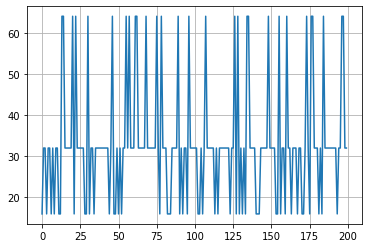

In [16]:
kpi_df.max_tile.plot()
plt.grid()

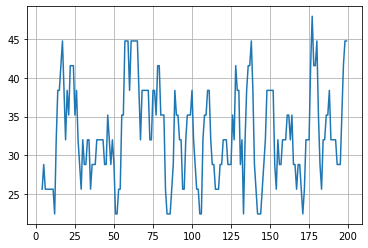

In [17]:
#smooth over 5 epochs

kpi_df.max_tile.rolling(5).mean().plot()
plt.grid()

## sum of tiles by epoch

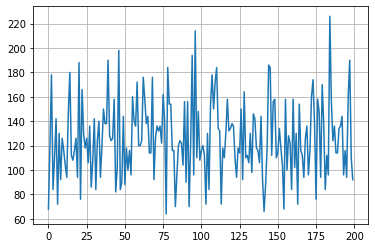

In [18]:
kpi_df.sum_of_tile.plot()
plt.grid()

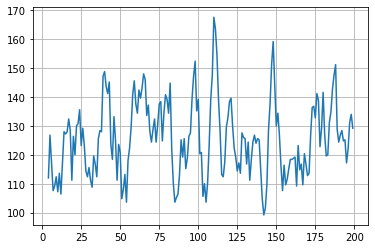

In [19]:
#smooth over 5 epochs

kpi_df.sum_of_tile.rolling(5).mean().plot()
plt.grid()

## total tries until game ends, by epoch

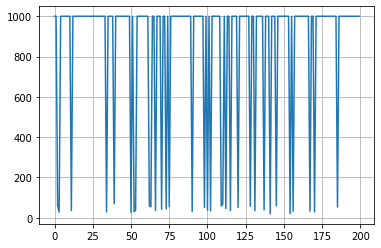

In [20]:
kpi_df.steps.plot()
plt.grid()